In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.model_selection import train_test_split
# Генератор дополнительных признаков
from sklearn.preprocessing import PolynomialFeatures
# Методы для масштабирования признаков
from sklearn.preprocessing import StandardScaler #, MinMaxScaler
# Модель линейной регрессии
from sklearn.linear_model import LinearRegression
# Модель лассо-регрессии с кросс-валидацией (L1-регуляризация)
from sklearn.linear_model import LassoCV
# Модель ридж-регрессии с кросс-валидацией (L2-регуляризация)
from sklearn.linear_model import RidgeCV
# Модель эластичная сеть (L1 и L2 регуляризация)
from sklearn.linear_model import ElasticNetCV
# MAE и MSE метрики для оценки работы обученной модели
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

In [2]:
# Загрузить данные в DataFrame из csv-файла
df = pd.read_csv('AB_NYC_2019_MY.csv')
df.sample(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
7318,Brooklyn,3917,40.71208,-73.95091,Entire home/apt,300,2,3,0.070000,1,0
627,Manhattan,1851,40.72264,-73.98370,Entire home/apt,160,4,0,1.373221,1,0
30295,Manhattan,1942,40.76000,-73.98962,Entire home/apt,175,3,4,0.260000,1,0


In [3]:
# Признаки - Features
featuresDF = df.drop('price', axis='columns')
# Целевая переменная
y = df['price']

In [4]:
# Получить только текстовые колонки из DataFrame'a
myObjectDf = featuresDF.select_dtypes(include='object')

# Создать из категориальных переменных Dummy переменные (one hot encoding)
myDummiesDf = pd.get_dummies(myObjectDf, drop_first=True)

for col in myDummiesDf.columns:
    tmp = myDummiesDf[col].apply(int)
    myDummiesDf[col] = tmp

In [5]:
# Получить все колонки исключая текстовые из DataFrame'a
myNumericDf = featuresDF.select_dtypes(exclude='object')

# Создать объект, с помощью которого будем генерировать
# дополнительные признаки для полиномиальной регрессии
polynomialConverter = PolynomialFeatures(
    # Полином какой степени нам нужен
    degree=3,
    # True: будут вычисляться только произведения признаков x1*x2
    # False: дополнительно вычисляются степени признаков (зависит от degree) x1^2, x2^2
    interaction_only=False,
    #
    include_bias=False
)

# Сгенерировать двумерный массив с исходными и дополнительными признаками
polyFeatures = polynomialConverter.fit_transform(myNumericDf)
print(polyFeatures.shape, end='\n\n');
#polyFeatures[0]

(48506, 164)



In [6]:
cols = []
for i in np.arange(0, polyFeatures.shape[1]):
    cols.append(f'col_{i}')

polyFeaturesDF = pd.DataFrame(polyFeatures, columns=cols)
# Собираем полный DataFrame с признаками
finalFeaturesDF = pd.concat([polyFeaturesDF, myDummiesDf], axis='columns')
finalFeaturesDF.shape

(48506, 170)

In [7]:
# Разбить набор данных на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(finalFeaturesDF, y, test_size=0.3, random_state=101)

In [8]:
# Создать объект для масштабирования признаков
standardScaler = StandardScaler()

# На основе анализа ТОЛЬКО тренировочных признаков,
# подготовить объект к масштабированию признаков
standardScaler.fit(X_train)  # ВАЖНО! В этот метод передаем только тренировочный набор признаков

# Масштабирование тренировочных признаков
# mean = 0; std = 1
X_scaled_train = standardScaler.transform(X_train)
#print(X_scaled_train.mean(), X_scaled_train.std(), end='\n\n');

# Масштабирование тестовых признаков
# mean = 0; std = 1
X_scaled_test = standardScaler.transform(X_test)
#print(X_scaled_test.mean(), X_scaled_test.std(), end='\n\n');
X_scaled_train.shape, y_train.shape

((33954, 170), (33954,))

In [9]:
# Создать объект модели обучения
linearRegressionModel = LinearRegression()
# Обучить модель
linearRegressionModel.fit(X_scaled_train, y_train)
# Вычислить целевые переменные, на основе обученной модели
yPredict = linearRegressionModel.predict(X_scaled_test)
#yPredict

In [10]:
# Среднее значение целевой переменной
yMean = df['price'].mean()

In [11]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 64.16228292381041

mse = 20463.516781082864

rmse = 143.0507489707162

rmse процент от yMean = 97%


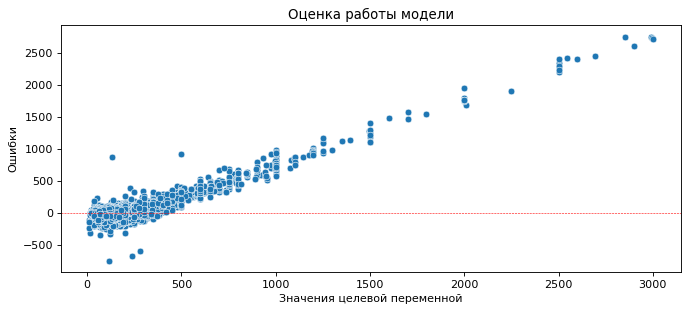

In [12]:
# Остатки (ошибки работы модели)
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [13]:
# Создать объект модели обучения
lassoCvModel = LassoCV(
    # Число, на основе которого вычисляется диапазон для значений лямбда-параметров
    # eps = alphaMin / alphaMax
    eps=0.001,
    # Количество лямбда-параметров для L1-регуляризации,
    # которые будут проверятся методом кросс-валидации
    n_alphas=100,
    cv=5,
    max_iter=1000000
)

# Обучить модель
lassoCvModel.fit(X_scaled_train, y_train)
#print(lassoCvModel.coef_, end='\n\n')

# Какое значение лямбда, по мнению модели L1-регуляризации, является наилучшим
alphaBest = lassoCvModel.alpha_
print(f'alphaBest = {alphaBest}', end='\n\n')

# Вычислить целевые переменные, на основе обученной модели
yPredict = lassoCvModel.predict(X_scaled_test)
#yPredict

alphaBest = 0.05809716685487486



In [14]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 65.76607113644812

mse = 20919.492528959945

rmse = 144.63572355735613

rmse процент от yMean = 98%


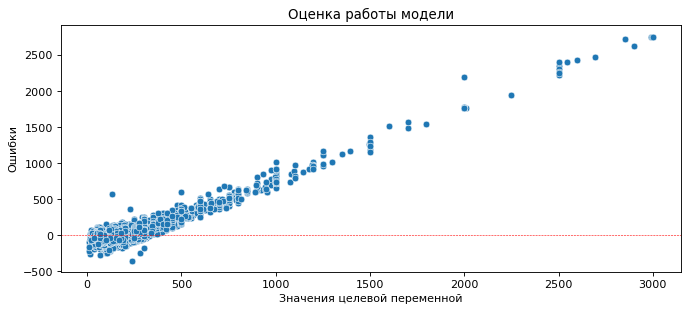

In [15]:
# Остатки (ошибки работы модели)
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [16]:
# Создать объект модели обучения
ridgeCvModel = RidgeCV(
    # Список лямбда-параметров для L2-регуляризации,
    # которые будут проверятся методом кросс-валидации
    alphas=(0.01, 0.05, 0.1, 0.15, 0.2, 1.0, 5.0, 10.0),
    cv=5,
    # Метрика, по которой будет выбираться наилучший результат
    # Здесь выбрали: Root Mean Square Error (RMSE) - среднеквадратическое отклонение
    scoring=('neg_root_mean_squared_error')
)

# Обучить модель
ridgeCvModel.fit(X_scaled_train, y_train)

# Какое значение лямбда, по мнению модели L2-регуляризации, является наилучшим
alphaBest = ridgeCvModel.alpha_
print(f'alphaBest = {alphaBest}'); print()

# Вычислить целевые переменные, на основе обученной модели
yPredict = ridgeCvModel.predict(X_scaled_test)
#yPredict

alphaBest = 0.01



In [17]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 64.60378691147808

mse = 20647.267100471363

rmse = 143.69156934375573

rmse процент от yMean = 98%


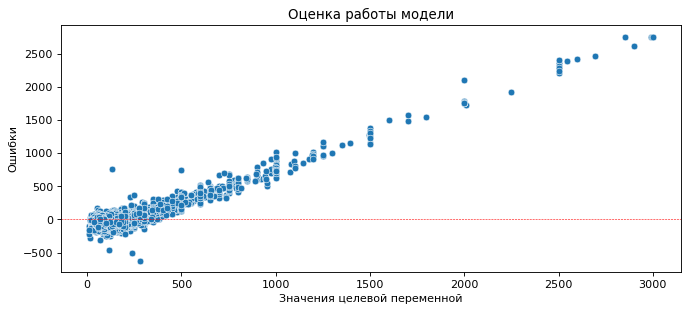

In [18]:
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [19]:
# Создать объект модели обучения
elasticCvModel = ElasticNetCV(
    # Соотношение между L1 и L2 в Elastic Net (L1 и L2 регуляризация)
    # l1_ratio=0.5,
    # Или список, из которого будет выбираться наилучшее значение
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    # Число, на основе которого вычисляется диапазон для значений лямбда-параметров
    # eps = alphaMin / alphaMax
    eps=0.001,
    # Количество лямбда-параметров для Elastic Net,
    # которые будут проверятся методом кросс-валидации
    n_alphas=100,
    cv=5,
    max_iter=1000000
)

# Обучить модель
elasticCvModel.fit(X_scaled_train, y_train)
#print(elasticCvModel.coef_, end='\n\n')

# Какое значение альфа, по мнению модели L1иL2-регуляризации, является наилучшим
alphaBest = elasticCvModel.l1_ratio_
print(f'alphaBest = {alphaBest}', end='\n\n')
# Какое значение лямбда, по мнению модели L1иL2-регуляризации, является наилучшим
lambdaBest = elasticCvModel.alpha_
print(f'lambdaBest = {lambdaBest}', end='\n\n')

# Вычислить целевые переменные, на основе обученной модели
yPredict = elasticCvModel.predict(X_scaled_test)
#yPredict

alphaBest = 1.0

lambdaBest = 0.05809716685487486



In [20]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 65.76607113644812

mse = 20919.492528959945

rmse = 144.63572355735613

rmse процент от yMean = 98%


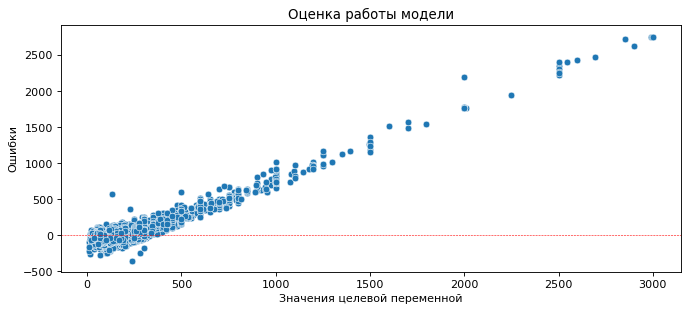

In [21]:
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [22]:
# Добавление полиномиальной регрессии никак не повлияло на качество работы.
# Результат как был неудовлетворительный, так и остался